In [1]:
import numpy as np
from scipy.optimize import minimize, least_squares, dual_annealing, differential_evolution

In [2]:
from typing import Callable, Tuple, List
import pandas as pd

In [80]:
import random
import math

In [81]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['font.size'] = 22
plt.rcParams['lines.markersize'] = 2

In [82]:
EPS = 1e-3

# Task 1

In [83]:
def plot_scatter_with_trends(x: List[float], y: List[float], trends: List[Tuple[List[float], List[float], str]], title: str):
    plt.scatter(x, y, label="generated data")
    for x, y, label in trends:
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

In [224]:
def run_differential_evolution(method: str,
              f: Callable[[float], float],
              jac: Callable[[float], float],
              x0: List[Tuple[float, float]],
              ranges: List[Tuple[float, float]], 
              tol: float) -> Tuple[float, int]:
    res = differential_evolution(func=f, bounds=ranges, tol=tol)
    return res.x, res.nit 

In [225]:
def run_dual_annealing(method: str,
              f: Callable[[float], float],
              jac: Callable[[float], float],
              x0: List[Tuple[float, float]],
              ranges: List[Tuple[float, float]], 
              tol: float) -> Tuple[float, int]:
    res = dual_annealing(func=f, x0=x0, bounds=ranges)
    return res.x, res.nit 

In [226]:
def run_minimize(method: str, 
                 f: Callable[[float], float], 
                 jac: Callable[[float], float],
                 x0: List[Tuple[float, float]],
                 ranges: List[Tuple[float, float]], 
                 tol: float) -> Tuple[float, int]:
    res = minimize(method=method, fun=f, x0=x0, bounds=ranges, tol=tol, jac=jac)
    return res.x, res.nit

In [227]:
def run_least_squares(method: str, 
                      f: Callable[[float], float],
                      jac: Callable[[float], float],
                      x0: List[Tuple[float, float]],
                      ranges: List[Tuple[float, float]], 
                      tol: float) -> Tuple[float, int]:
    res = least_squares(method=method, fun=f, x0=x0, xtol=tol)
    return res.x, res.nfev

In [228]:
def run_gradient_descent(method: str, 
                        f: Callable[[float], float],
                        jac: Callable[[float], float],
                        x0: List[Tuple[float, float]],
                        ranges: List[Tuple[float, float]], 
                        tol: float, 
                        learning_rate = 1e-2, 
                        max_epochs = 1e8) -> Tuple[float, int]:
    it = 0
    while it < max_epochs:
        it += 1
        delta = learning_rate * jac(x0)
        if np.all(np.abs(delta) < tol / 10):
            break
        x0 -= delta
        
    return x0, it

In [229]:
methods = [('lm', run_least_squares),
           ('Nelder-Mead', run_minimize),
           ('Simulated Annealing', run_dual_annealing),
           ('Differential Evolution', run_differential_evolution)
          ]

In [230]:
def run_f(f: Callable[[float], float], x: float, inv: List[int]) -> float:
    inv[0] += 1
    return f(x)

In [231]:
def run_optimization(optimizer, 
                     method: str,
                     f: Callable[[float], float], 
                     jac: Callable[[float], float],
                     x0: List[Tuple[float, float]],
                     ranges: List[Tuple[float, float]], 
                     tol: float) -> Tuple[float, int, int]:
    inv = [0]
    opt, it = optimizer(method, lambda x: run_f(f, x, inv), jac, x0, ranges, tol)
    return opt, it, inv[0]

In [232]:
def f(x, a, b, c, d):
    return (a * x + b) / (x ** 2 + c * x + d)

def f_jac(x, a, b, c, d):
    return np.array([x / (x * x + c * x + d), 
                     1 / (x * x + c * x + d),
                     -x / (x * x + c * x + d) ** 2,
                     -1 / (x * x + c * x + d) ** 2
                    ])
def f_limited(x, a, b, c, d, limit=100):
    y = f(x, 0, 1, -3, 2)
    y[y > limit] = limit
    y[y < -limit] = -limit
    return y

In [233]:
N = 1000
x = np.array([3 * k / 1000 for k in range(N)])
y = f_limited(x, 0, 1, -3, 2) + np.random.normal(0, 1, N)

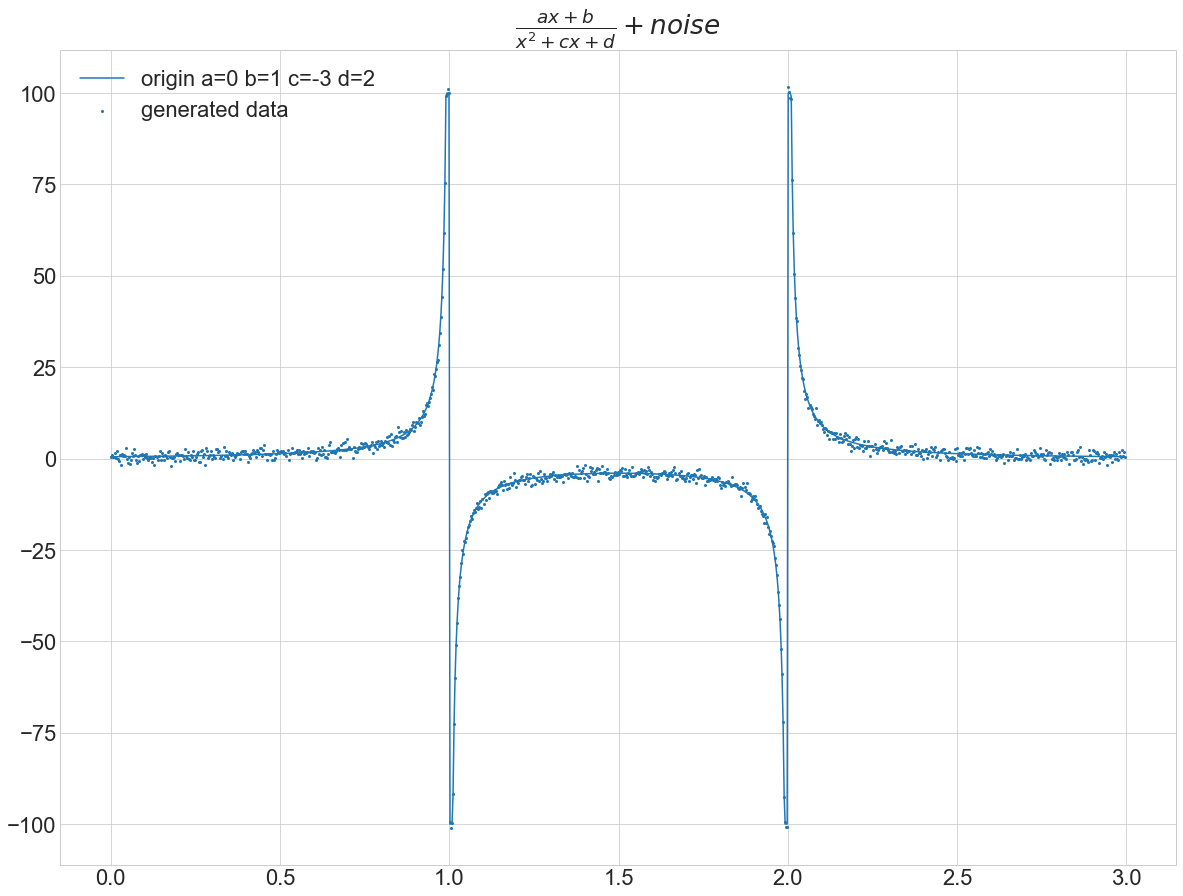

In [234]:
plot_scatter_with_trends(x, y, [(x, f_limited(x, 0, 1, -3, 2), "origin" + (" a=%.0f b=%.0f c=%.0f d=%.0f" % (0, 1, -3, 2)))], r'$\frac{ax + b}{x^2 + cx + d} + noise$')

In [235]:
def d(f, a, b, c, d, x, y):
    return (np.square(f(x, a, b, c, d) - y)).mean(axis=0)

def d_jac(f, f_jac, a, b, c, d, x, y):
    d_df = np.full(x.shape, 2 * (f(x, a, b, c, d) - y))
    df = f_jac(x, a, b, c, d)
    return np.array([(d_df * df[0]).mean(axis=0), (d_df * df[1]).mean(axis=0)])

In [236]:
def minimize_multidimensional_function(f_: Callable[[float, float, float], float], 
                                       f_jac_: Callable[[float, float, float], float],
                                       f_ranges: List[Tuple[float, float]], f_name: str) -> pd.DataFrame:
    
    results = []
    trends = [(x, f_limited(x, 0, 1, -3, 2), "origin")]
    x0 = np.array([random.uniform(low, hight) for low, hight in f_ranges])
    
    for method, optimizer in methods:
        if method == 'lm':
            f = lambda p: f_(x, p[0], p[1], p[2], p[3]) - y
            jac = lambda p: f_jac_(x, p[0], p[1], p[2], p[3])
        else:
            f = lambda p: d(f_, p[0], p[1], p[2], p[3], x, y)
            jac = lambda p: d_jac(f_, f_jac_, p[0], p[1], p[2], p[3], x, y)
            
        opt, it, inv = run_optimization(optimizer, method, f, jac, x0, f_ranges, EPS)
        mse = d(f_, opt[0], opt[1], opt[2], opt[3], x, y)
        results.append([f'${f_name}$', method, f_ranges, np.around(opt, 5), mse, it, inv])
        trends.append((x, f_(x, opt[0], opt[1], opt[2], opt[3]), method))
    
    plot_scatter_with_trends(x, y, trends, f_name)
    df = pd.DataFrame.from_records(results, columns=['function', 'method', 'range', '[a, b, c, d]', 'mse', 'iteratins', 'invocations'])
    return df

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


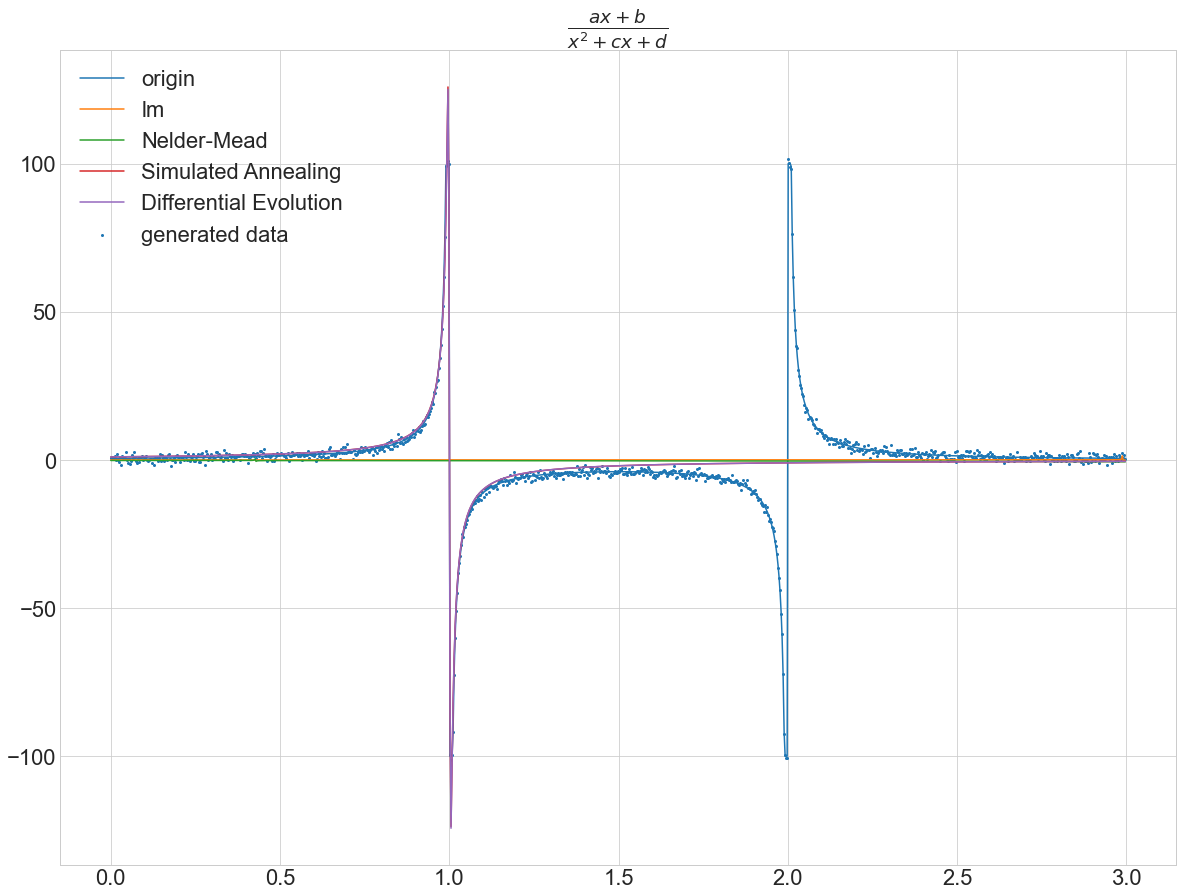

,function,method,range,"[a, b, c, d]",mse,iteratins,invocations
0,$$\frac{ax + b}{x^2 + cx + d}$$,lm,"[[-1, 1], [0, 2], [-4, -2], [1, 3]]","[-0.00053, 1e-05, -3.50566, 1.5456]",268.115843,14,25
1,$$\frac{ax + b}{x^2 + cx + d}$$,Nelder-Mead,"[[-1, 1], [0, 2], [-4, -2], [1, 3]]","[0.93407, -0.3967, -4.84209, 1.88526]",268.085239,115,210
2,$$\frac{ax + b}{x^2 + cx + d}$$,Simulated Annealing,"[[-1, 1], [0, 2], [-4, -2], [1, 3]]","[-1.0, 1.00049, -2.00091, 1.00092]",136.125081,1000,9146
3,$$\frac{ax + b}{x^2 + cx + d}$$,Differential Evolution,"[[-1, 1], [0, 2], [-4, -2], [1, 3]]","[-0.99269, 0.9932, -2.001, 1.00101]",136.132397,144,8765


In [237]:

fuction = (f, f_jac, [[-1, 1], [0, 2], [-4, -2], [1, 3]], r'$\frac{ax + b}{x^2 + cx + d}$')
minimize_multidimensional_function(*fuction)

# Task 2

In [32]:
import re
city_coords = []
with open('lau15_dist.coord.txt', 'r') as city_coord_file:
    for city_coord_line in city_coord_file.readlines()[8:]:
        city_coords.append(list(map(float, re.split('\s+', city_coord_line.strip()))))
print(*city_coords, sep='\n')

[5.49963e-08, 9.85808e-09]
[-28.8733, -7.97739e-08]
[-79.2916, -21.4033]
[-14.6577, -43.3896]
[-64.7473, 21.8982]
[-29.0585, -43.2167]
[-72.0785, 0.181581]
[-36.0366, -21.6135]
[-50.4808, 7.37447]
[-50.5859, -21.5882]
[-0.135819, -28.7293]
[-65.0866, -36.0625]
[-21.4983, 7.31942]
[-57.5687, -43.2506]
[-43.07, 14.5548]


In [37]:
city_dists = []
with open('lau15_dist.txt', 'r') as city_dist_file:
    for city_dist_line in city_dist_file.readlines()[2:]:
        city_dists.append(list(map(int, re.split('\s+', city_dist_line.strip()))))
print(*city_dists, sep='\n')

[0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46]
[29, 0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21]
[82, 55, 0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51]
[46, 46, 68, 0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64]
[68, 42, 46, 82, 0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23]
[52, 43, 55, 15, 74, 0, 61, 23, 55, 31, 33, 37, 51, 29, 59]
[72, 43, 23, 72, 23, 61, 0, 42, 23, 31, 77, 37, 51, 46, 33]
[42, 23, 43, 31, 52, 23, 42, 0, 33, 15, 37, 33, 33, 31, 37]
[51, 23, 41, 62, 21, 55, 23, 33, 0, 29, 62, 46, 29, 51, 11]
[55, 31, 29, 42, 46, 31, 31, 15, 29, 0, 51, 21, 41, 23, 37]
[29, 41, 79, 21, 82, 33, 77, 37, 62, 51, 0, 65, 42, 59, 61]
[74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65, 0, 61, 11, 55]
[23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61, 0, 62, 23]
[72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62, 0, 59]
[46, 21, 51, 64, 23, 59, 33, 37, 11, 37, 61, 55, 23, 59, 0]


In [42]:
city_tsp = []
with open('lau15_tsp.txt', 'r') as city_tsp_file:
    for city_tsp_line in city_tsp_file.readlines()[5:]:
        city_tsp.append(list(map(int, re.split('\s+', city_tsp_line.strip())))[0] - 1)
print(*city_tsp)

0 12 1 14 8 4 6 2 11 13 9 7 5 3 10


In [134]:
def show_tsp(paths: List[Tuple[List[int], str]], coords: List[List[int]]):
    plt.rcParams['lines.markersize'] = 10
    for path, label in paths:
        x, y = [], []
        for v in path:
            x.append(coords[v][0])
            y.append(coords[v][1])
        x.append(x[0])
        y.append(y[0])
        plt.plot(x, y, 'o-', label=label)
        plt.legend()
        plt.show()    

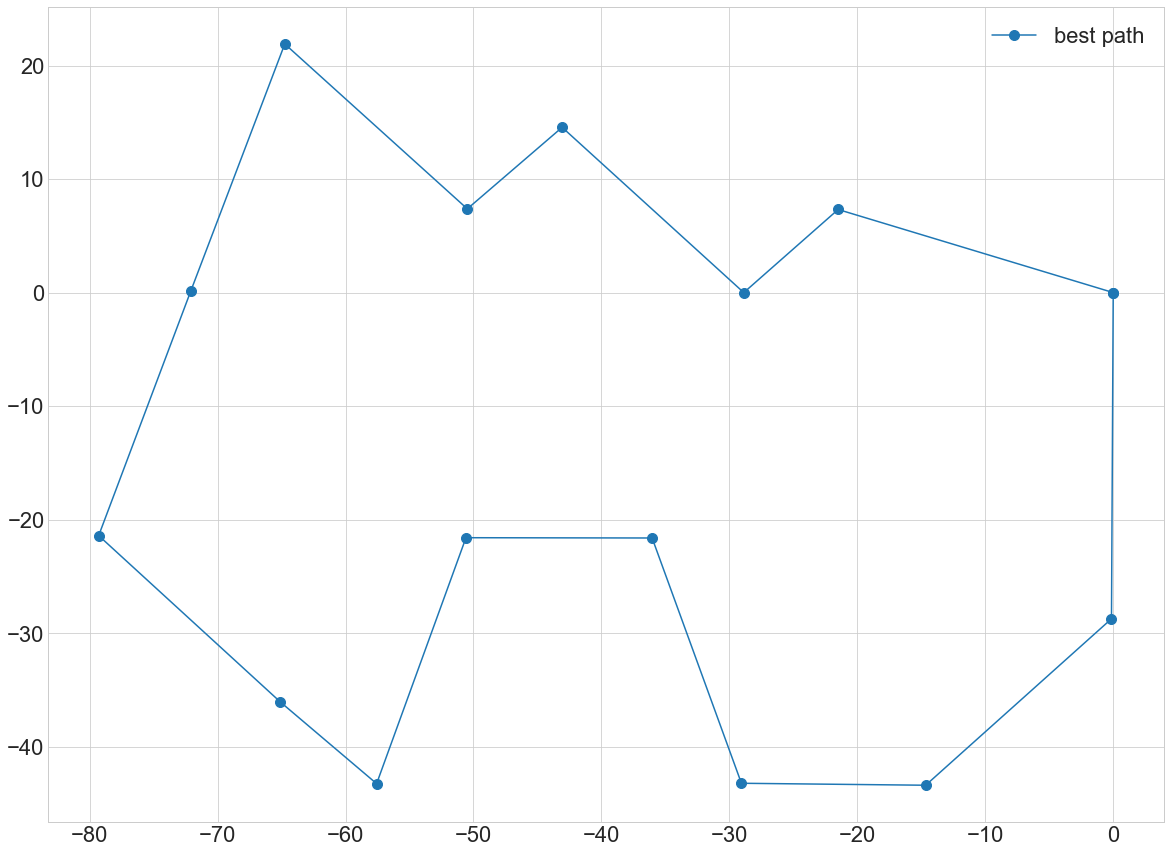

In [135]:
show_tsp([[city_tsp, 'best path']], city_coords)

In [168]:
def get_path_distance(path: List[List[int]]) -> float:
    d = 0
    for i in range(len(path)):
        d += city_dists[path[i]][path[(i + 1) % len(path)]]
    return d

In [220]:
def annealing(initial_path: List[List[int]], 
              t_begin=1.0e+3, 
              t_end=1, 
              c=.999, 
              it=5):
    best_path = initial_path
    best_d = get_path_distance(best_path)
    
    for _ in range(it):
        step = 0
        t = t_begin
        cur_path = initial_path.copy()
        cur_d = get_path_distance(cur_path)

        step = 0
        while t > t_end:
            path = cur_path.copy()

            index = random.sample(range(len(initial_path)), 2)
            path[index[0]], path[index[1]] = path[index[1]], path[index[0]]
            d = get_path_distance(path)

            diff = d - cur_d
            if diff < 0 or math.exp(-diff / t) > random.random():
                cur_path, cur_d = path, d

            if cur_d < best_d:
                best_path, best_d = cur_path, cur_d
                
            t = t * c
            step = step + 1
    return best_path, step


In [221]:
initial_path = list(range(15))
random.shuffle(initial_path)
best_path, step = annealing(initial_path.copy())
print(f'steps count: {step}')
print(f'recieved path length: {get_path_distance(best_path)}')
print(f'optimal path length: {get_path_distance(city_tsp)}')


steps count: 6905
recieved path length: 291
optimal path length: 291


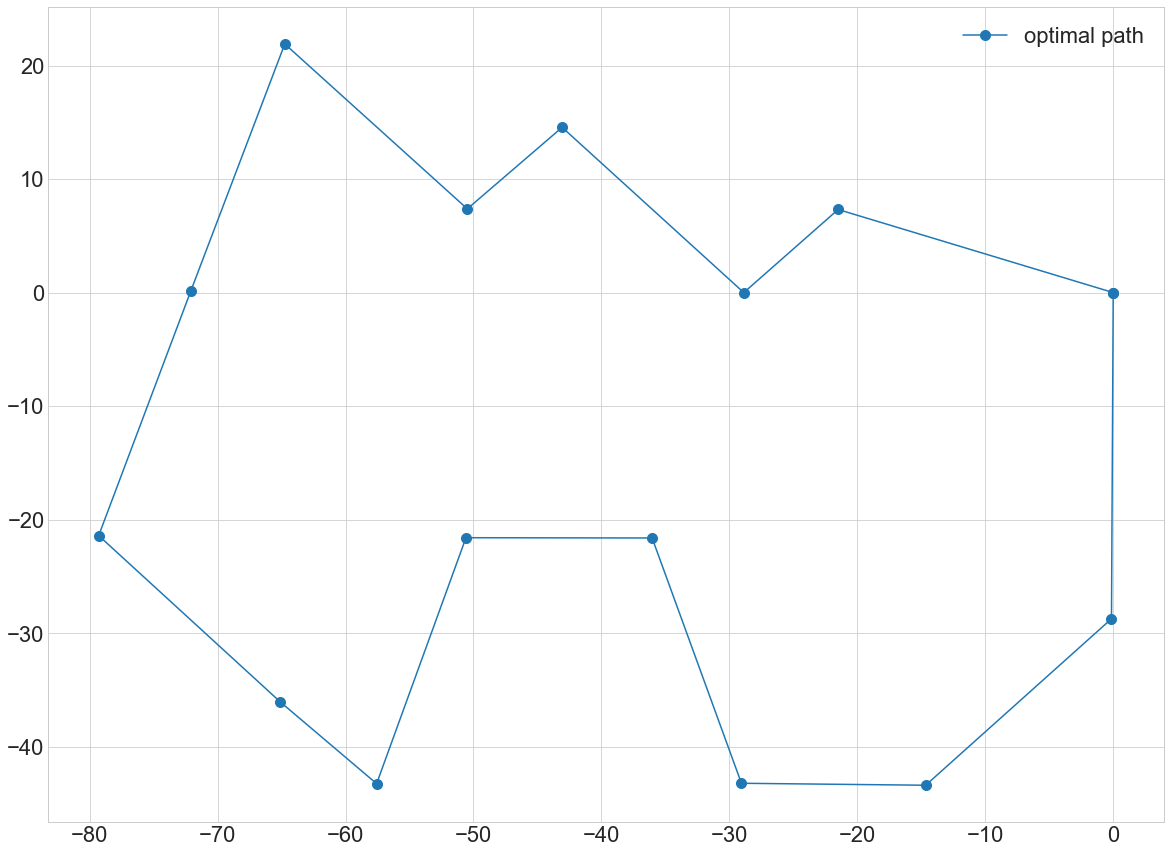

In [222]:
show_tsp([[city_tsp, 'optimal path']], city_coords)

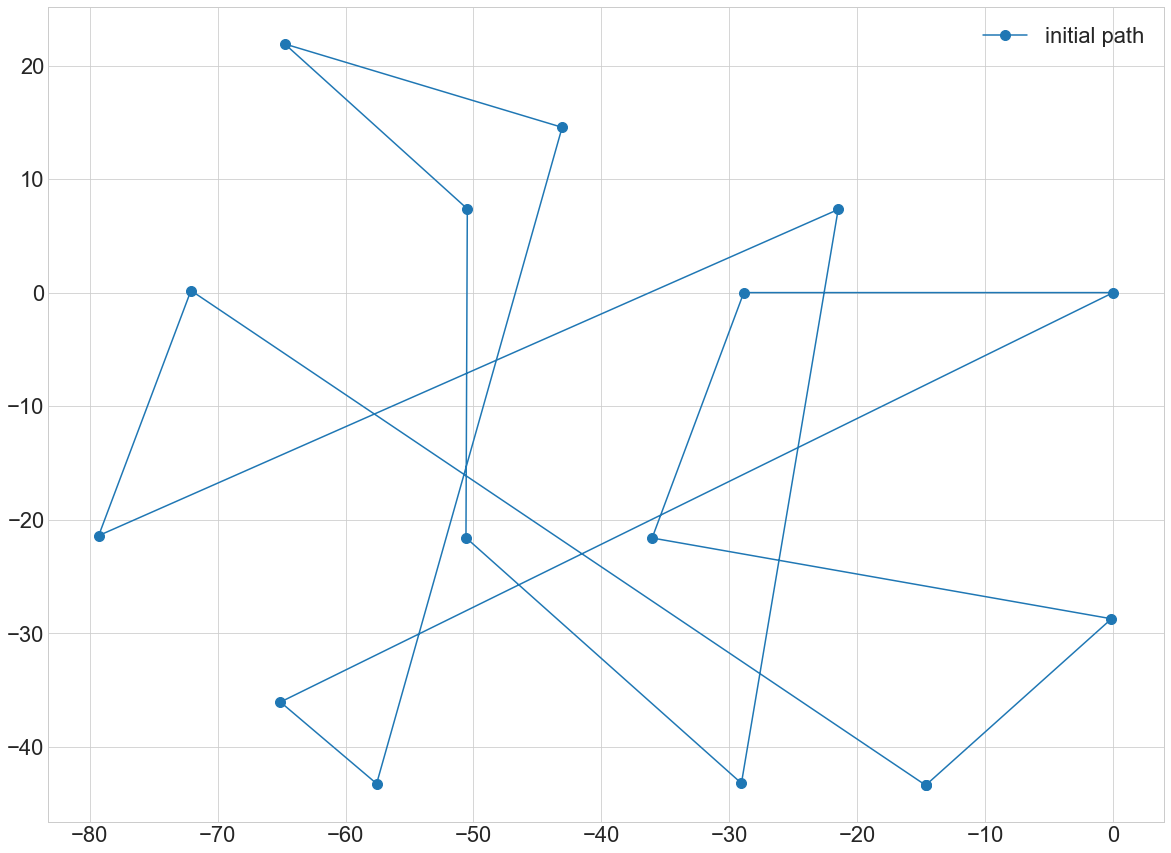

In [223]:
show_tsp([[initial_path, 'initial path']], city_coords)

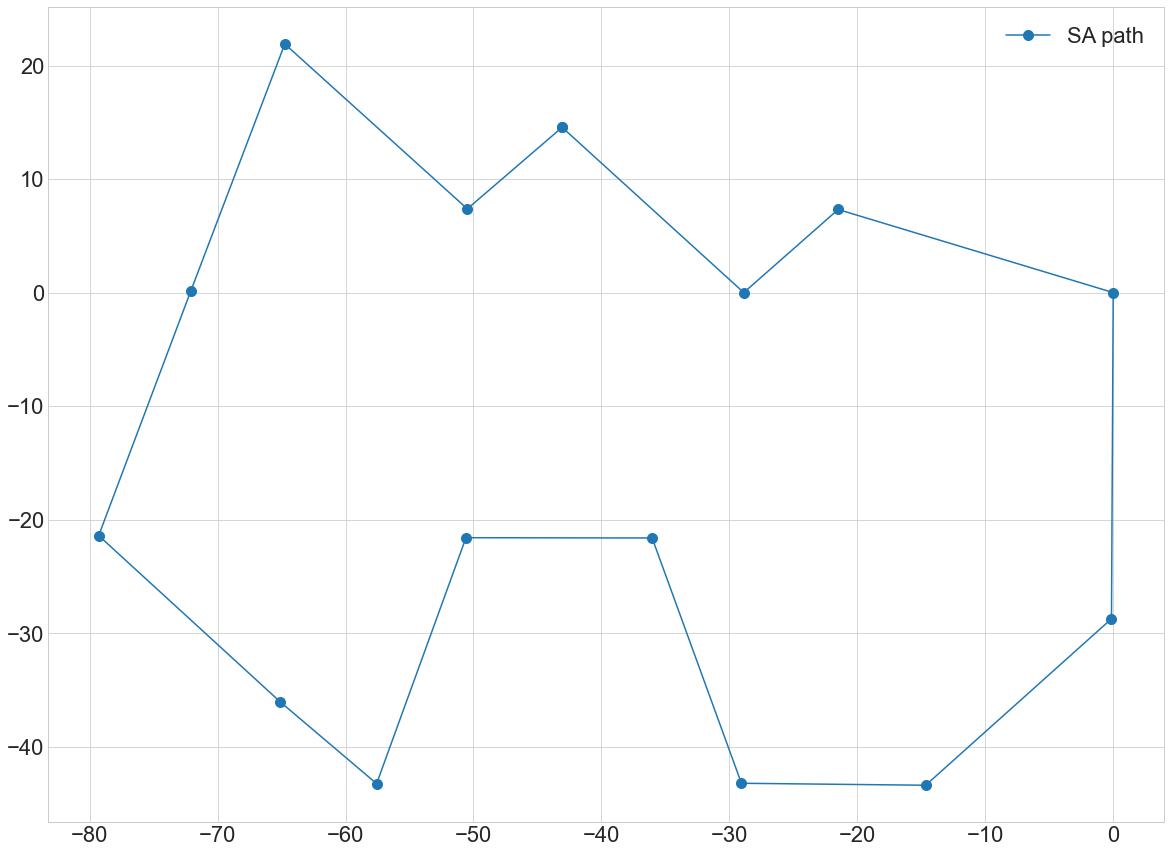

In [224]:
show_tsp([[best_path, 'SA path']], city_coords)